![Samples of TFIM](figs/SetOfSamples.png)


# <span style="color:darkslategray">  Tutorial on Reconstructing Quantum States with Positive-Operator Valued Measurements (POVMs) and Recurrent Neural Networks </span>



Michael Albergo

A walkthrough of using Pepinillo to reproduce results from https://arxiv.org/pdf/1810.10584.pdf by Juan Carrasquilla, Giacomo Torlai, Roger Melko, and Leandro Aolita.



RNN Model includes sampler, used later for visualization. Hyperparameters defined in cell 3 other than learning rate

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
#import palettable
import seaborn as sns

# <span style="color:steelblue"> Setting the Scenario </span>

Imagine you are trying to prepare a 50-qubit quantum system that is governed by the Transverse-Field Ising Model 1D  Hamiltonian: 
<img src="figs/TransverIsingModel1DHamiltonian.png" alt="TFIMHamiltonian" width="300"/>

You want to be able to check on the fidelity of your setup to verify that you have properly prepared the quantum state. To do this, you want to perform inference on the density matrix of the mixed state -- to show that informationally complete measurement samples from your setup match the expected frequency associated with your intended density matrix $\rho$. With the right choice of measurements -- namely informationally complete Postive-Operator Valued Measurements for each qubit $M = \{ M^{(\mathbf{a_i})} \otimes \dots \otimes M^{(\mathbf{a_n})} \}$, we can link the probability of measurement outcomes with the invertible expression given by Born's Rule: $P(\mathbf{a}) = \mathrm{Tr}[M^{(\mathbf{a})}\rho]$. Thus, if we can gain insight into the distribution of measurement ourcomes $P(\mathbf{a})$, we can gain insight into the density matrix $\rho$. Here, each $a_i$ in $\mathbf{a}$ can take on a discrete value to represent the measurement outcome for the $i^{th}$ qubit. The number of possible outcomes is decided by which POVM measurements are used.


## <span style="color:steelblue">How do we learn $P(\mathbf{a})$? Recurrent Neural Networks </span>

Modern machine learning methods offer a variety of methods for learning some generative distribution $p(x)$. In this tutorial, we treat our qubit measurements as sequential measurements (though the order is arbitrary) and apply a recurrent neural network model made of 2 linked gated recurrent units (GRUs). I'll explain these a bit below.

In a generative recurrent model, we can represent the joint ditribution $p(\mathbf{a})$ over all N qubit measurement outcomes by factorizing it according to the chain rule:

\begin{equation} p(\mathbf{a}) = p(a_1) p(a_2 | a_1) p(a_3 | a_1, a_2)...p(a_N | a_1, \dots, a_{N-1})\end{equation}

The idea here is to make estimates of each of these factors sequentially with subsequent passes through the recurrent unit. An RNN is composed of some fundamental cell, which is some weight matrix or set of weight matrices that are fixed after training and a hidden state $h_t$ whose value is updated at each sequential step.


#### TO DO
SHOW DIAGRAM OF RNN and specifically GRU, explain how probability measures over one-hot vectors are calculated at each time step and passed forward through the RNN again with different h_t

Pauli-4 TFIM data. Datafile is named "numpy_POVM_data.npz"

In [51]:
device = torch.device("cuda:0" if torch.cuda.device_count() != 0 else "cpu")
print(device)

n_qubits = 50
n_outcomes =4
batchSize =50
hidden_size = 100
num_gru_layers = 2
num_epochs = 50
log_interval = 50
loss_by_step = True
lr = 0.0001

cpu


In [23]:


data_array = np.load('data/TFIM_training_data.npz')['data']
log_probs = np.load('data/TFIM_logprobs.npz')['probs']
#print(data_array.shape)

In [ ]:
print(data_array.shape, log_probs[:10])

In [28]:
# NOW THE DATA IS OF THE SHAPE [n_samples x n_qubits x n_outcomes]

reshaped_array = np.empty((data_array.shape[0], 50, 4))
for i in range(data_array.shape[0]):
    reshaped_array[i] = data_array[i].reshape((50,4))


In [52]:
# I LOAD THE DATA INTO A PYTORCH DATALOADER CLASS

tensor_array_train = torch.stack([torch.Tensor(i).double() for i in reshaped_array[:50000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i).double() for i in reshaped_array[50000:100000]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=1)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 1)
print(train_loader)

In [61]:
# I BUILD THE MODEL, WITH FUNCTIONS FOR INITIALIZING THE HIDDEN STATE AND THE INITIAL X
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_gru_layers
        self.steps = n_qubits
        self.n_outcomes = n_outcomes
        self.loss_by_step = loss_by_step
        self.batchSize = batchSize

        
        self.rnn = nn.GRU(n_outcomes, hidden_size, num_layers=self.num_layers, dropout=0.01)
        self.outcome = nn.Linear(hidden_size, n_outcomes)
        #self.outcome2 = nn.Linear(hidden_size // 2, n_outcomes)
        self.CE = nn.CrossEntropyLoss()
        
        
    
    def initHidden(self):
        
        '''
        must be shape 
        [self.num_layers * num_directions (1 in this case), batchSize, hidden_size]
        '''
        return torch.zeros(1*self.num_layers, batchSize, self.hidden_size).to(device).double()
    
    def initX(self):
        '''
        must be shape 
        [(1 step), batchSize, hidden_size]
        '''
        return torch.zeros(1, batchSize, self.n_outcomes).to(device).double()
    

    def step(self, input, hidden):
        
        output, hidden = self.rnn(input, hidden)
        for_prediction = output.squeeze(0).to(device)
        outcome_prob = F.softmax(self.outcome(for_prediction), dim = 1)
        return output, hidden, outcome_prob

    
    def forward(self, inputs, hidden=None,  steps=50):
        
        '''
        must be shape
        input: [length_sequence (n_qubits), batchSize, num_features (n_outcomes)]
        hidden: [num_layers * num_directions, batchSize, hidden_size]'''
        
        if steps == 0: steps = len(inputs)
        outputs = torch.ones(steps, batchSize, hidden_size).double().to(device)
        outcome_probs = torch.ones(steps, batchSize, n_outcomes).double().to(device)
        #losses = torch.tensor(1).double().to(device)
        losses = torch.zeros(steps, batchSize)

        for i in range(steps):
            if  i == 0:
                hidden = self.initHidden()
                input = self.initX()
                inputX = input
                targets = torch.argmax(inputs[i],dim=1)
                
            else:
                input = inputs[i-1,:,:].unsqueeze(0)
                targets = torch.argmax(inputs[i],dim=1)
                

                
            output, hidden, outcome = self.step(input, hidden)

            if self.loss_by_step == True:
                #loss_i = self.CE(outcome, targets.long())
                #loss_i = self.step_loss(targets, outcome)
                loss_i = self.myCrossEntropyLoss(outcome, targets)
                losses[i,:] = loss_i
            outputs[i] = output
            outcome_probs[i] = outcome
            
        if loss_by_step == False:
            losses = self.loss_overall(inputs, outcome_probs)
            
        loss = torch.sum(losses)
        return outputs, hidden, outcome_probs, loss, inputX
       

    def myCrossEntropyLoss(self, outputs, labels):
        batch_size = outputs.size()[0]            # batch_size
        outputs = torch.log(outputs)   # compute the log of softmax values
        outputs = outputs[range(batch_size), labels] # pick the values corresponding to the labels
        #print(outputs.shape)
        return -torch.sum(outputs)/batch_size
    
    
    def sample(self):
    
        #initialize hidden as in model
        hidden = self.initHidden()
        inputX = self.initX()
        
        # one hot encoded for each qubit
        samples = torch.zeros(self.steps, self.batchSize, self.n_outcomes)
        probs = torch.zeros(self.batchSize)

        #go through all qubits
        for i in range(self.steps):

            #initialize for one-hot encoding, qubit_i_samples will be a class chosen for each batch entry based on probabilities
            # batchSize number of samples for ith qubit
            qubit_i_samples = torch.zeros(self.batchSize)
            if i == 0:
                output, hidden, outcome = self.step(inputX, hidden)
                qubit_i_probs = outcome.to('cpu').data.numpy()
            elif i > 0:
                output, hidden, outcome = self.step(input.unsqueeze(0).to(device).double(), hidden)
                qubit_i_probs = outcome.to('cpu').data.numpy()

            for batch_entry in range(self.batchSize):

                qubit_i_samples[batch_entry] = torch.from_numpy(np.random.choice([0,1,2,3], size = 1, p=qubit_i_probs[batch_entry]))

            #make the one-hot samples, use to feed as next input
            samples[i][torch.arange(qubit_i_samples.shape[0]).long(), qubit_i_samples.long()] = 1
            input = samples[i]

        return samples
    
    
    
    
    def step_loss(self, real_outcomes, predicted_outcomes, ce = True):
    
        if ce is True:
            loss = F.cross_entropy(predicted_outcomes, real_outcomes.long(), size_average=False)
        else:
            one_hot_Trueoutcomes = torch.zeros((real_outcomes.shape[0], real_outcomes.max()+1))
            one_hot_Trueoutcomes[torch.arange(real_outcomes.shape[0]).long(),real_outcomes.long()] = 1
            loss = F.mse_loss(one_hot_Trueoutcomes.to(device).double(), predicted_outcomes, size_average=False)
        return loss

#     def loss_overall(self, real_outcomes, predicted_outcomes, ce = True):
    
#         if ce is True:
#            # CE = F.cross_entropy(real_outcomes[1:], predicted_outcomes[:-1], size_average=False)
#             real_outcomes_1 = real_outcomes.view(batchSize*self.steps,4)
#             target_labels = torch.argmax(real_outcomes_1,dim=1).long()
#             predictions = predicted_outcomes.view(batchSize*self.steps,4)
            
#             # take cross entropy between the output prediction and the true target label.
#             loss = F.cross_entropy(predictions, target_labels, size_average=False)
#         else:
#             loss = F.mse_loss(real_outcomes, predicted_outcomes, size_average=False)

#         return loss
    
    
    

    
model = RNN(hidden_size).to(device).double()
optimizer = optim.Adam(model.parameters(), lr=lr)
    
    

In [62]:
train_losses = []
KLs = []
fidelities = []
for epoch in range(1, num_epochs + 1):
    #train(epoch, train_losses)
    train_loss = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device).permute(1,0,2)#.reshape(n_qubits, batchSize, n_outcomes)
        
        #if batch_idx == 1:
         #   print(data[:,0])
        optimizer.zero_grad()
        outputs, hidden, outcome_probs, loss, inputX = model(data)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            KL, fidelity = compute_KL(model)
            
            KLs.append(KL)  
            fidelities.append(fidelity)  
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data[1]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data[1]) ))
    avg_batch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_batch_loss)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_batch_loss))

Train Epoch: 1 [0/50000 (0%)]	Loss: 67.314175
Train Epoch: 1 [2500/50000 (5%)]	Loss: 58.401528
Train Epoch: 1 [5000/50000 (10%)]	Loss: 53.613506
Train Epoch: 1 [7500/50000 (15%)]	Loss: 53.299243
Train Epoch: 1 [10000/50000 (20%)]	Loss: 54.197041
Train Epoch: 1 [12500/50000 (25%)]	Loss: 53.478223
Train Epoch: 1 [15000/50000 (30%)]	Loss: 53.125913
Train Epoch: 1 [17500/50000 (35%)]	Loss: 52.095884
Train Epoch: 1 [20000/50000 (40%)]	Loss: 54.508584
Train Epoch: 1 [22500/50000 (45%)]	Loss: 53.918032
Train Epoch: 1 [25000/50000 (50%)]	Loss: 52.051968
Train Epoch: 1 [27500/50000 (55%)]	Loss: 53.467480
Train Epoch: 1 [30000/50000 (60%)]	Loss: 52.770684
Train Epoch: 1 [32500/50000 (65%)]	Loss: 53.372427
Train Epoch: 1 [35000/50000 (70%)]	Loss: 54.084663
Train Epoch: 1 [37500/50000 (75%)]	Loss: 52.315718
Train Epoch: 1 [40000/50000 (80%)]	Loss: 51.353467
Train Epoch: 1 [42500/50000 (85%)]	Loss: 53.728120
Train Epoch: 1 [45000/50000 (90%)]	Loss: 52.024243
Train Epoch: 1 [47500/50000 (95%)]	Loss:

Process Process-121:
Process Process-105:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Mike_Laptop/anaconda/envs/pytorch04/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/Mike_Laptop/anaconda/envs/pytorch04/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/Mike_Laptop/anaconda/envs/pytorch04/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Mike_Laptop/anaconda/envs/pytorch04/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Mike_Laptop/anaconda/envs/pytorch04/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/Users/Mike_Laptop/anaconda/envs/pytorch04/lib/python3.7/site-packages/torch/utils/data/dataloader.py"

KeyboardInterrupt: 

[16.41803627092471, 6.785061214108551, 2.6601099194404534, 2.4880913985337907, 2.4032390145467017, 2.329265442681507, 2.2503691576130174, 2.187526424860788, 2.122240731321872, 2.0534727213767385, 1.9927927892962438, 1.918602013999055, 1.8425421168680582, 1.750638953441216, 1.5770185536320385, 1.3142991649126168, 0.939870227220997, 0.8073947239520483, 0.7610213049022821, 0.7217837110131617, 0.7067285227373712, 0.6768145469860835, 0.657871798741704, 0.6365439343292251, 0.6145350879102698, 0.5976556138042916, 0.5883465512722573, 0.5750219928149305, 0.5564537451720577, 0.5486006918547202, 0.5316099128737437, 0.5167472905262084, 0.5186516690190582, 0.516302833606136, 0.4888175575444763] [0.014548790404223385, 0.16014533848923926, 0.530042186162865, 0.5543364972865763, 0.569603698649495, 0.5800494689120282, 0.5937369135256707, 0.6066077972698248, 0.6120342814462201, 0.626617320862637, 0.6352044178088604, 0.6479175407839312, 0.6569045695495898, 0.6719082990052876, 0.6975889793804485, 0.751260

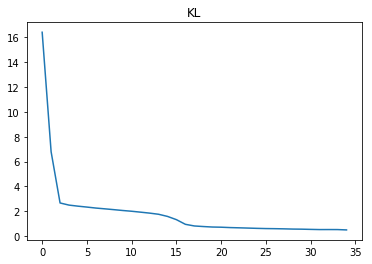

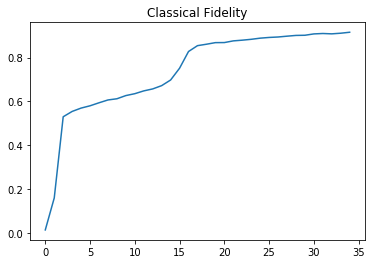

In [64]:
print(KLs, fidelities)
plt.plot(range(len(KLs)), KLs)
plt.title("KL")
plt.show()
plt.plot(range(len(KLs)), fidelities)
plt.title("Classical Fidelity")
plt.show()

In [72]:
## try sampling from it, compute average probability of each outcome
sample_test = model.sample()
#compare probabilities:
#print(sample_test[:,0,:])
bin_counts = [np.bincount(np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1)) for i in range(batchSize) ]
#print(bin_counts)
print("Real Percent distribution for 50 qubtis:", true_percentages)
print("Percent distribution for the 50 qubits:",(np.array(bin_counts).mean(0) / np.array(bin_counts).mean(0).sum()))
print("Outcome distribution for the 50 qubits:",np.array(bin_counts).mean(0))

Real Percent distribution for 50 qubtis: [0.16663017 0.05579797 0.16662539 0.61094647]
Percent distribution for the 50 qubits: [0.178  0.0488 0.164  0.6092]
Outcome distribution for the 50 qubits: [ 8.9   2.44  8.2  30.46]


<Figure size 1080x72 with 0 Axes>

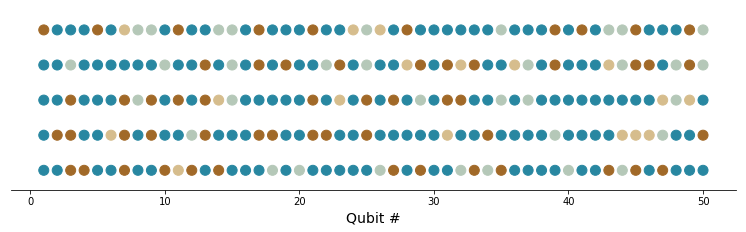

In [12]:
def plot_samples(sample_test = sample_test, n_samples = 1, n_qubits = n_qubits):
    qubits = np.arange(1, n_qubits + 1)
    color_labels = np.array([np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1) for i in range(batchSize)])#[0.456,0.962,0.231] 
    #print(color_labels[0].shape, qubits.shape)
    #UnlabelledY=[0,1,0]
    fig = plt.figure(figsize=(15,1))
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    muted=["#4878CF", "#6ACC65", "#D65F5F",
               "#B47CC7", "#C4AD66", "#77BEDB"]
    #my_cmap = ListedColormap(sns.color_palette(muted).as_hex())
    #cmap = sns.cubehelix_palette(light=0.8, dark=0.4, start=0.03, rot=0.4, as_cmap=True)
    cmap = ListedColormap(palettable.cartocolors.diverging.Earth_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Chevalier_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Darjeeling2_5.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Moonrise2_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.FantasticFox2_5.mpl_colors)
    print(cmap)
    
    if n_samples == 1:
        fig = plt.figure(figsize=(15,1))
        plt.scatter(qubits, np.zeros_like(qubits), 
                c=color_labels[0], cmap=cmap, vmin=0, s=120)
        #plt.axis('off')
        plt.xlabel("Qubit #", fontsize=14)
    else:
        fig, axes = plt.subplots(n_samples, 1, figsize=(13,n_samples * 0.66))
        fig.subplots_adjust(hspace=-0.1)
        for i in range(n_samples):
            axes[i].scatter(qubits, np.zeros_like(qubits), 
                    c=color_labels[i], cmap=cmap, vmin=0, s=100)
            axes[i].set_yticks([])
            sns.despine(left=True, bottom=True)
            #sns.despine(bottom=True)
            #sns.despine(top=True)
            if i == n_samples - 1:
                axes[i].set_xlabel("Qubit #", fontsize=14)
                axes[i].spines["bottom"].set_visible(True)
            else:
                axes[i].set_xticks([])

    plt.show()
    return

plot_samples(sample_test = sample_test, n_samples = 5, n_qubits = 50)


In [22]:
#batchSize = 50
#batchSize = 100
index = np.random.randint(0,len(data_array))
test = reshaped_array[index:index+batchSize]
data = torch.from_numpy(test).double().to(device)
#print(data.shape)
#print(inputX.shape)
#print(hidden.shape)

#output, hidden, outcome, loss, inputX = model(data)

def sample(model, n_qubits, batchSize = batchSize, hidden_size = hidden_size, n_outcomes = n_outcomes, num_layers = num_gru_layers):
    
    #initialize hidden as in model
    hidden = torch.ones(1*num_layers, batchSize, hidden_size).to(device).double()
    initX = torch.ones(1, batchSize, n_outcomes).to(device).double()
    samples = torch.zeros(n_qubits, batchSize, n_outcomes)
    
    for i in range(n_qubits):
        
        #initialize for one-hot encoding, qubit_i_samples will be a class chosen for each batch entry based on probabilities
        # batchSize number of samples for ith qubit
        qubit_i_samples = torch.zeros(batchSize)

        if i == 0:
            output, hidden, outcome = model.step(initX, hidden)
            qubit_i_probs = outcome.to('cpu').data.numpy()
            #print(qubit_i_probs[0])
        elif i > 0:
            output, hidden, outcome = model.step(samples[i-1].unsqueeze(0).to(device).double(), hidden)
            qubit_i_probs = outcome.to('cpu').data.numpy()
            print(qubit_i_probs[0])
            
        for batch_entry in range(batchSize):
            qubit_i_samples[batch_entry] = torch.from_numpy(np.random.choice([0,1,2,3], size = 1, p=qubit_i_probs[batch_entry]))
        samples[i][torch.arange(batchSize).long(), qubit_i_samples.long()] = 1
        input = samples[i]
        #print(samples[i])
 
        #samples[i] = sample_i
    
    return samples
            
sample_test = sample(model, 50)  


#compare probabilities:
print(sample_test.shape)
bin_counts = [np.bincount(np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1)) for i in range(batchSize) ]
print((np.array(bin_counts).mean(0) / np.array(bin_counts).mean(0).sum()))
print(np.array(bin_counts).mean(0))

[0.24731441 0.09571714 0.16840106 0.48856739]
[0.28633727 0.04534951 0.14410022 0.524213  ]
[0.13532165 0.03683293 0.13004007 0.69780535]
[0.27190482 0.04626563 0.13021532 0.55161423]
[0.11645201 0.03883645 0.12715262 0.71755892]
[0.10684544 0.04460918 0.14531526 0.70323013]
[0.08712651 0.03907288 0.13931167 0.73448894]
[0.28296597 0.04690094 0.12639971 0.54373337]
[0.04318725 0.0602801  0.13571295 0.7608197 ]
[0.3122509  0.05655144 0.12372435 0.50747331]
[0.05551038 0.06884588 0.18043632 0.69520741]
[0.31565521 0.05835189 0.12255458 0.50343832]
[0.06727131 0.04602498 0.12838432 0.75831939]
[0.17353235 0.03079436 0.1409004  0.6547729 ]
[0.16428146 0.03719234 0.12376445 0.67476174]
[0.19678972 0.05619844 0.18482432 0.56218752]
[0.11086062 0.13486727 0.16491337 0.58935873]
[0.07180931 0.05507153 0.14189156 0.73122761]
[0.28739894 0.04433333 0.1342459  0.53402183]
[0.11332769 0.03741628 0.12614935 0.72310668]
[0.2375404  0.03876015 0.13116001 0.59253944]
[0.11038084 0.05103628 0.18253137 

In [50]:
def compute_KL(model, real_data = reshaped_array, logPs = log_probs, num_samples = 150, num_layers = num_gru_layers):

    KL = 0
    fidelity = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device).permute(1,0,2)
        
        outputs, hidden, outcome_probs, loss, inputX = model(data)
        logq_batch = (torch.sum(torch.log(torch.sum(outcome_probs * data, dim=2)), dim=0))
        KL += np.sum(logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] - logq_batch.cpu().data.numpy())
        fidelity += np.sum(np.exp((1/2) * (logq_batch.cpu().data.numpy() - logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] )))
        
        if batch_idx == 25:
            break
    
    KL = KL / (batchSize * batch_idx)
    
    fidelity = fidelity / (batchSize*batch_idx)
       
    return KL, fidelity

kl, fidelity = compute_KL(model)   


print(kl, fidelity)
  

2.0541447587635693 0.6280019870649907


In [162]:
print((torch.sum(torch.log(torch.sum(outcome_probs * data, dim=2)), dim=0)))
print(torch.sum(outcome_probs * data, dim=2).shape)
#print(log_probs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)])

tensor([-48.7280, -57.7980, -46.2830, -58.3975, -59.0218, -56.3116,
        -41.7687, -43.3531, -50.9076, -50.4845, -61.5539, -52.6993,
        -48.2108, -56.4936, -46.2790, -55.4091, -50.6446, -47.1339,
        -46.2462, -52.9736, -54.9653, -52.7664, -53.5814, -61.8175,
        -48.5956, -55.0955, -58.5391, -60.3642, -46.3613, -41.6966,
        -62.0812, -49.5609, -43.9365, -53.0663, -48.6884, -43.4069,
        -58.3538, -51.2023, -50.3998, -46.7518, -59.9154, -43.3103,
        -54.4262, -48.5549, -45.9686, -50.3093, -57.9838, -54.4279,
        -55.5317, -50.1821, -46.3783, -57.1653, -50.1031, -50.4617,
        -56.5617, -43.6189, -41.4486, -53.4316, -59.9795, -49.4824,
        -54.4331, -53.8996, -43.6240, -47.3441, -52.9975, -40.0012,
        -53.2560, -55.8943, -47.1756, -54.9125, -47.6753, -53.8624,
        -59.3871, -54.1255, -52.6482, -54.3610, -43.2094, -48.9391,
        -51.6604, -45.8431, -61.7252, -45.8633, -49.1761, -38.6988,
        -42.0896, -44.5974, -53.9904, -47.0573, 

In [67]:
counts = []
for i in range(len(data_array)):
    #print(np.argmax(data_array[i]).shape)
    count = np.bincount(np.argmax(reshaped_array[i], axis=1))
    counts.append(count)
    #break
    #for j in range(len(data_array[i])):
       # print(data_array[i][j])  
   # if i == 50:
    #    break

In [68]:
counts[:50]

[array([ 6,  5, 10, 29]),
 array([11,  0,  8, 31]),
 array([ 9,  3,  8, 30]),
 array([11,  3, 10, 26]),
 array([ 7,  5, 11, 27]),
 array([ 7,  2,  6, 35]),
 array([ 7,  4,  8, 31]),
 array([11,  1,  8, 30]),
 array([ 6,  4,  3, 37]),
 array([13,  0,  5, 32]),
 array([ 6,  0,  7, 37]),
 array([ 6,  3,  7, 34]),
 array([ 6,  4,  6, 34]),
 array([ 9,  5,  3, 33]),
 array([ 9,  8,  7, 26]),
 array([ 5,  1, 12, 32]),
 array([ 7,  1,  7, 35]),
 array([ 5,  2,  9, 34]),
 array([11,  1,  5, 33]),
 array([13,  5,  3, 29]),
 array([ 8,  0,  9, 33]),
 array([ 5,  0, 11, 34]),
 array([ 8,  3, 10, 29]),
 array([ 7,  5,  6, 32]),
 array([ 5,  4,  9, 32]),
 array([ 8,  3,  8, 31]),
 array([10,  1,  2, 37]),
 array([ 8,  4, 10, 28]),
 array([ 7,  3, 15, 25]),
 array([ 8,  4,  9, 29]),
 array([10,  1,  9, 30]),
 array([ 3,  2, 11, 34]),
 array([ 8,  4, 12, 26]),
 array([ 8,  1,  8, 33]),
 array([ 8,  4,  9, 29]),
 array([ 4,  1, 10, 35]),
 array([ 7,  3,  7, 33]),
 array([ 8,  6,  8, 28]),
 array([11, 

In [70]:
means = np.array(counts).mean(0)
print(means)
true_percentages = means / (means.sum())
print(means / (means.sum()))

[ 8.33150833  2.78989853  8.33126961 30.54732353]
[0.16663017 0.05579797 0.16662539 0.61094647]


In [66]:
## testing my own cross entropy

numpy = torch.from_numpy(reshaped_array[0])
labels = torch.argmax(numpy,dim=1)
numpy = torch.log(numpy)
numpy[0] = torch.log(torch.from_numpy(np.array([0.75,0.2,0,0.05])))
print(numpy)
print(labels)

tensor([[-0.2877, -1.6094,    -inf, -2.9957],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,  0.0000,    -inf],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,  0.0000,    -inf,    -inf],
        [   -inf,  0.0000,    -inf,    -inf],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,  0.0000,    -inf],
        [ 0.0000,    -inf,    -inf,    -inf],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,    -inf,  0.0000],
        [   -inf,    -inf,  0.0000,    -inf],
        [   -inf,    -inf,  0.0000

In [ ]:
output_vals = numpy[range(50), labels]
print(output_vals)

In [ ]:
sample_test[:,0,:].shape